In [52]:
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#passwords and tokens specific for each twitter user
access_token = 'your_access_token'
access_token_secret = 'your access token secret'
consumer_key = 'your consumer key'
consumer_secret = 'your consumer secret'

In [20]:
#class for Twitter client
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
    
    def get_user_timeline_tweets(self, num_tweets):
        tweets =[]
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list =[]
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor (self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [7]:
#class for Twitter authentification
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        
        return auth

In [8]:
#class responsible for streaming and processing live tweets
class TwitterStreamer():
    def __init__(self):
        self.twitter_authetificator = TwitterAuthenticator()
    
    def stream_tweets(self, fetched_tweets, hash_tag_list):
        #This handles Twitter authentication and connection to Twitter Streaming API
        listener = TwittertListener() #obiekt klasy TwitterListener, który dziedziczy po tej klasie
        auth = self.twitter_authetificator.authenticate_twitter_app()
        stream = Stream(auth, listener)
        #this line filters Twitter Streams to capture data by the keywords
        stream.filter(track=hash_tag_list)

In [9]:
#Basic Listener class that prints received tweets to output
class TwitterListener(StreamListener):
    
    def __init__(self, fetched_tweets):
        self.fetched_tweets = fetched_tweets
        
    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print ('Error on_data: %s' % str(e))
        return True
        
    def on_error(self, status):
        if status == 420:
            #returning False on_error method in case rate limit occurs
            return False
        print(status)

In [61]:
#class for analysing and categorizing content from tweets
class TweetAnalyzer():
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['length'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['like'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        return df

In [65]:
if __name__ == '__main__':
    
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    api = twitter_client.get_twitter_client_api()
    
    tweets = api.user_timeline(screen_name='Scienceofsport', count=400)
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    print(np.mean(df['length']))
    print(np.max(df['like']))
    print(np.max(df['retweets']))
    #print(df)
    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)
    #print(tweets[0].id)

136.415
159
1432


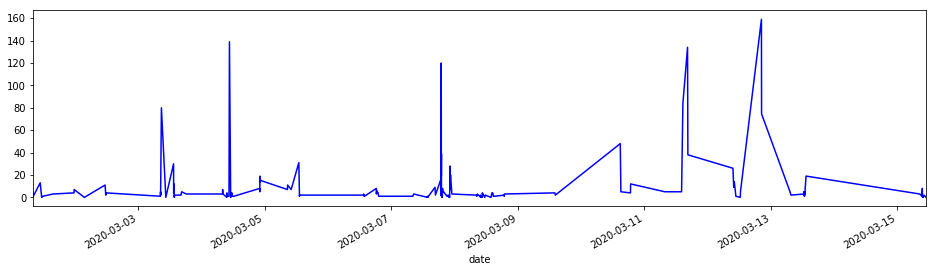

In [66]:
#visualization of number of likes during the time
time_likes = pd.Series(data = df['like'].values, index = df['date'])
time_likes.plot(figsize=(16,4), color='b')
plt.show()

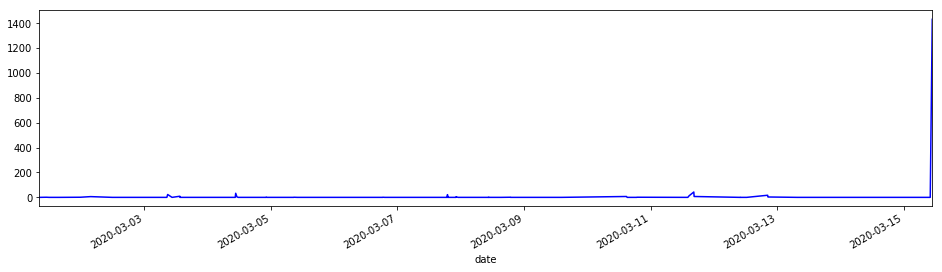

In [67]:
time_likes = pd.Series(data = df['retweets'].values, index = df['date'])
time_likes.plot(figsize=(16,4), color='b')
plt.show()

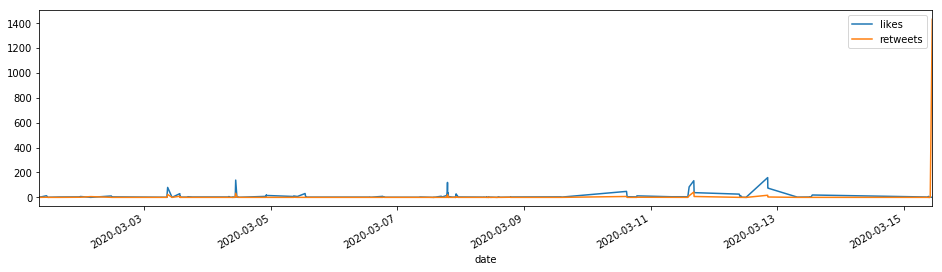

In [68]:
#both graphs on one plot
time_likes = pd.Series(data = df['like'].values, index = df['date'])
time_likes.plot(figsize=(16,4), label='likes', legend=True)

time_likes = pd.Series(data = df['retweets'].values, index = df['date'])
time_likes.plot(figsize=(16,4), label='retweets', legend=True)
plt.show()

Sentiment analysis

In [69]:
from textblob import TextBlob
import re

In [70]:
tweet_analyzer = TweetAnalyzer()
df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

In [72]:
df['sentiment'].value_counts()

 1    88
 0    82
-1    30
Name: sentiment, dtype: int64